In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

# Results Analysis

# Method 1

In [2]:
def changefinder(file, oberservation_type, startweek = 0, endweek = -1):
    if file is None:
        data2 = [50]*100 +[25]*100 + [75]*100 +[100]*100
        data2 = [50]*100
    else:
        data = pd.read_csv(file)
    
        data2 = data.replace('<1',0.5).values[1:]
    data3 = []
    
    for i in data2[startweek : endweek]:
        data3.append(int(i))
        
    values = np.array(data3) #count_data in the book
    weeks = len(values) #n_count_data in the book
    alpha = 1.0 / weeks
    
    with pm.Model() as model:
        #Period one: 0-Tau: lambda_1
        lambda_1 = pm.Exponential("lambda_1", alpha)
        #Period two: Tau-Tau_2: lambda_2
        lambda_2 = pm.Exponential("lambda_2", alpha)
        #Period three: Tau_2-Tau_3: lambda_3
        lambda_3 = pm.Exponential("lambda_3", alpha)
        #Period four: Tau_3-End: lambda_4
        lambda_4 = pm.Exponential("lambda_4", alpha)

        tau_2 = pm.DiscreteUniform("tau_2", lower = 0, upper = weeks)
        tau = pm.DiscreteUniform("tau", lower = 0, upper = tau_2)
        tau_3 = pm.DiscreteUniform("tau_3", lower = tau_2, upper = weeks)

        idx = np.arange(weeks) # Index
        lambda_ = pm.math.switch(idx < tau, lambda_1,
                                 pm.math.switch(idx < tau_2, lambda_2, 
                                                pm.math.switch(idx < tau_3, lambda_3, lambda_4))) 
        
        
        if oberservation_type == "Poisson distribution":
            observation = pm.Poisson("obs", lambda_, observed = values)
            
        if oberservation_type == "Negative binomial distribution":
            alpha_nb = pm.Exponential("alpha_nb", 0.5)
            observation = pm.NegativeBinomial("obs", mu = lambda_, alpha = alpha_nb, observed = values)
            
        if oberservation_type == "Zero-inflated Poisson":
            psi = pm.Beta("psi", 1/2, 1/2)
            observation = pm.ZeroInflatedPoisson("obs", psi = psi, mu = lambda_, observed = values)
            
        if oberservation_type == "Normal dististribution":
            observation = pm.Normal('obs', mu = lambda_, observed = values) 
            
        #fix and check    
        if oberservation_type == "Binomial distribution":
            #Period one: 0-Tau: P_1
            P_1 = pm.Uniform("P_1", 0,1)
            #Period two: Tau-Tau_2: P_2
            P_2 = pm.Uniform("P_2", 0,1)
            #Period three: Tau_2-Tau_3: P_3
            P_3 = pm.Uniform("P_3", 0,1)
            #Period four: Tau_3-End: P_4
            P_4 = pm.Uniform("P_4", 0,1)
            
            P_ = pm.math.switch(idx < tau, P_1,
                         pm.math.switch(idx < tau_2, P_2, 
                                        pm.math.switch(idx < tau_3, P_3, P_4))) 
            
            observation = pm.Binomial('obs', n = np.max(values), p = P_, observed = values) #fix
            
        if oberservation_type == "T Student distribution":
            # sigma = , lam = , (other possible parameters)
            pm.StudentT('obs', nu = 100, mu = lambda_, observed = values)

        step = pm.Metropolis()
        trace = pm.sample(10000, tune = 5000, step = step, return_inferencedata = False)
        
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    lambda_3_samples = trace['lambda_3']
    lambda_4_samples = trace['lambda_4']
    
    if oberservation_type == "Binomial distribution":
        P_1_sample = trace['P_1']
        P_2_sample = trace['P_2']
        P_3_sample = trace['P_3']
        P_4_sample = trace['P_4']
    
    tau_samples = trace['tau']
    tau_2_samples = trace['tau_2']
    tau_3_samples = trace['tau_3']

    N = tau_samples.shape[0]
    expected_texts_per_day = np.zeros(weeks)
    for day in range(0, weeks):
        ix_1 = day < tau_samples
        
        ix2_upperbound = (day < tau_2_samples)
        ix2_lowerbound = (day > tau_samples)
        ix_2 = np.logical_and(ix2_upperbound, ix2_lowerbound)

        ix3_upperbound = (day < tau_3_samples)
        ix3_lowerbound = (day > tau_2_samples)
        ix_3 = np.logical_and(ix3_upperbound, ix3_lowerbound)

        ix_4 = day > tau_3_samples
        
        if oberservation_type == "Binomial distribution":
            expected_texts_per_day[day] = 100*(P_1_sample[ix_1].sum()
                                   + P_2_sample[ix_2].sum()
                                  +  P_3_sample[ix_3].sum()
                                  + P_4_sample[ix_4].sum()) / N
        else:
            expected_texts_per_day[day] = (lambda_1_samples[ix_1].sum()
                                           + lambda_2_samples[ix_2].sum()
                                          + lambda_3_samples[ix_3].sum()
                                          + lambda_4_samples[ix_4].sum()) / N
    
    # plt.rcParams['figure.figsize'] = [10, 7]
    # plt.plot(range(weeks), expected_texts_per_day, color="#E24A33", lw=4,
    #          label = f"Expected number of search results received according to a {oberservation_type} based model")
    
    # if endweek == -1:
    #     plt.xlim(startweek, weeks)
    # else:
    #     plt.xlim(startweek, endweek)
    # plt.bar(np.arange(weeks), values, color="#348ABD", alpha=0.5,
    #         label="Observed searches per day")
    # name = file
    # plt.xlabel("Week")
    # plt.ylabel("Search results (recorded as a percentage of the peak amount))")
    # plt.title(f"Did the amount of {file} change over time?")
    
    # plt.legend(loc="upper left")
    # #plt.savefig("/Desktop/dissertation/Elden Ring stuff", transparent=None, dpi='figure', format="jpeg")
    
    differences = ( np.array(expected_texts_per_day) - np.array(values) )**2
    MSE = ( sum(differences)/len(values) )
    #print('The MSE is:', MSE)
    return MSE, expected_texts_per_day

In [3]:
os.chdir('/Users/elliotbarlow/Desktop/dissertation/')
with open("results for method 1.obj", "rb") as filehandler:
    results_table = pickle.load(filehandler)

results_database =  pd.DataFrame(results_table, columns=['Year', 'Game', 'Type of search results file', 'Distribution', 'MSE of prediction', 'Actual Data', 'Prediction'])
results_database

,Year,Game,Type of search results file,Distribution,MSE of prediction,Actual Data,Prediction
0,2022,Pokemon Legends Arceus,news searches.csv,Poisson distribution,68.994598,"[14, 21, 27, 50, 89, 100, 63, 46, 32, 37, 23, ...","[44.4390040255263, 44.4390040255263, 44.439004..."
1,2022,Pokemon Legends Arceus,news searches.csv,Negative binomial distribution,62.150788,"[14, 21, 27, 50, 89, 100, 63, 46, 32, 37, 23, ...","[48.327287708730054, 47.936351795683706, 47.98..."
2,2022,Pokemon Legends Arceus,news searches.csv,Zero-inflated Poisson,69.033995,"[14, 21, 27, 50, 89, 100, 63, 46, 32, 37, 23, ...","[50.26333344036274, 50.26333344036274, 50.2633..."
3,2022,Pokemon Legends Arceus,news searches.csv,Normal dististribution,68.303418,"[14, 21, 27, 50, 89, 100, 63, 46, 32, 37, 23, ...","[47.89798240135901, 47.89798240135901, 47.8979..."
4,2022,Pokemon Legends Arceus,news searches.csv,Binomial distribution,62.747016,"[14, 21, 27, 50, 89, 100, 63, 46, 32, 37, 23, ...","[45.70659751935671, 45.70659751935671, 45.7065..."
...,...,...,...,...,...,...,...
1453,2023,Mortal Kombat 1,web searches.csv,Negative binomial distribution,113.814788,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.14772179101516011, 0.14772179101516011, 0.1..."
1454,2023,Mortal Kombat 1,web searches.csv,Zero-inflated Poisson,105.786168,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5133750408688811, 0.5133750408688811, 0.513..."
1455,2023,Mortal Kombat 1,web searches.csv,Normal dististribution,129.329652,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.83161676828061, 3.83161676828061, 3.8316167..."
1456,2023,Mortal Kombat 1,web searches.csv,Binomial distribution,104.766985,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9494180130965358, 0.9494180130965358, 0.949..."


## Analysis of all data

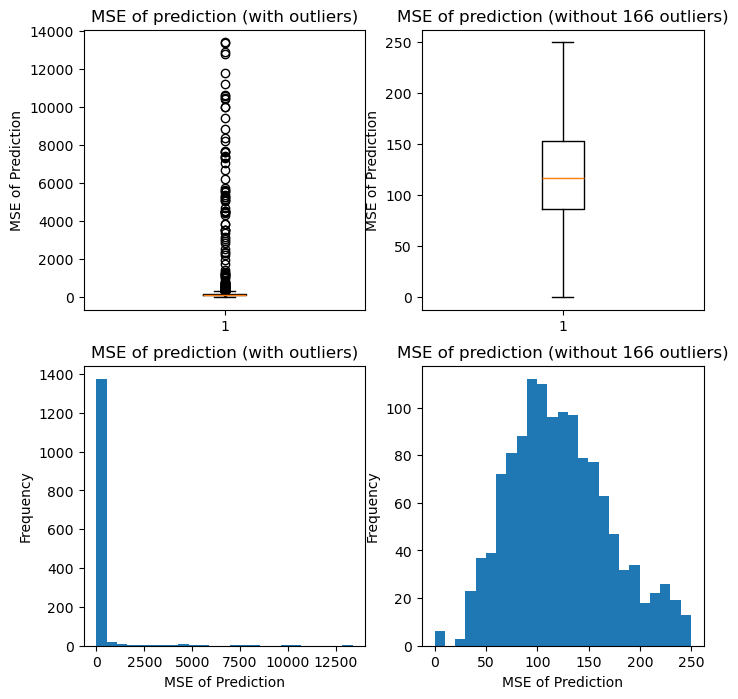

In [4]:
MSE_results = np.array(results_database['MSE of prediction'])
MSE_results_filtered = np.array(results_database['MSE of prediction'][results_database['MSE of prediction']<=250 ])
plt.figure(figsize = [8,8])
plt.subplot(221)
plt.boxplot(MSE_results)
plt.ylabel('MSE of Prediction')
plt.title("MSE of prediction (with outliers)")


plt.subplot(222)
plt.boxplot(MSE_results_filtered)
plt.ylabel('MSE of Prediction')
plt.title(f"MSE of prediction (without {len(MSE_results)- len(MSE_results_filtered)} outliers)")


plt.subplot(223)
plt.hist(MSE_results, bins=25)
plt.xlabel('MSE of Prediction')
plt.ylabel('Frequency')
plt.title("MSE of prediction (with outliers)")

plt.subplot(224)
plt.hist(MSE_results_filtered, bins=25)
plt.xlabel('MSE of Prediction')
plt.ylabel('Frequency')
plt.title(f"MSE of prediction (without {len(MSE_results)- len(MSE_results_filtered)} outliers)")

plt.show()


### Best ten predictions (We will later find this to not be true)

In [5]:
best_10_predictions = results_database.sort_values("MSE of prediction", ascending=True).head(10)
best_10_predictions

,Year,Game,Type of search results file,Distribution,MSE of prediction,Actual Data,Prediction
1032,2023,Crime Boss Rockay City,news searches.csv,Poisson distribution,0.000273,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.00948736855959272, 0.018813347361972994, 0...."
1266,2023,Metroid Prime Remastered,news searches.csv,Poisson distribution,0.000400,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.02319848074309835, 0.02390694826836533, 0.0..."
1271,2023,Metroid Prime Remastered,news searches.csv,T Student distribution,0.008530,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.009157323417159106, 0.10366563955100577, 0...."
1035,2023,Crime Boss Rockay City,news searches.csv,Normal dististribution,0.008718,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.032921979861653856, 0.09910427701574918, 0...."
1037,2023,Crime Boss Rockay City,news searches.csv,T Student distribution,0.009715,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.06393304393057932, 0.10522625230681204, 0.1..."
1269,2023,Metroid Prime Remastered,news searches.csv,Normal dististribution,0.009926,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.054731038879755715, 0.10562576924155365, 0...."
613,2022,The Quarry,youtube searches.csv,Negative binomial distribution,27.990182,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, ...","[0.6582037459286264, 0.6582037459286264, 0.658..."
462,2022,Sonic Frontiers,web searches.csv,Poisson distribution,29.412171,"[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3.272368685971072, 3.272368685971072, 3.27236..."
355,2022,A Plague Tale Requiem,web searches.csv,Negative binomial distribution,29.590318,"[1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, ...","[1.9444681653539653, 1.9444681653539653, 1.944..."
464,2022,Sonic Frontiers,web searches.csv,Zero-inflated Poisson,30.175078,"[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3.2722679539313297, 3.2722679539313297, 3.272..."


### Worst ten predictions

In [6]:
worst_10_predictions = results_database.sort_values("MSE of prediction", ascending=True).tail(10)
worst_10_predictions

,Year,Game,Type of search results file,Distribution,MSE of prediction,Actual Data,Prediction
37,2022,Mario Strikers Battle League,news searches.csv,Negative binomial distribution,10392.606200,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[114.16939429161458, 115.44641300510929, 115.0..."
379,2022,Cult of the Lamb,news searches.csv,Negative binomial distribution,10467.204689,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[112.8237779576958, 112.4170899633684, 111.747..."
361,2022,Cuphead The Delicious Last Course,news searches.csv,Negative binomial distribution,10574.755897,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[111.45912172031751, 111.04460817352074, 111.1..."
163,2022,Nobody Saves the World,news searches.csv,Negative binomial distribution,10636.264977,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 95, 0, 0, 0,...","[113.40731334950355, 113.20137801101279, 112.9..."
380,2022,Cult of the Lamb,news searches.csv,Zero-inflated Poisson,11196.977623,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[105.47812710563767, 105.99255987910642, 105.8..."
55,2022,Tunic,news searches.csv,Negative binomial distribution,11749.056741,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0...","[115.0316482134761, 114.6606769809533, 115.234..."
470,2022,OlliOlli World,news searches.csv,Zero-inflated Poisson,12758.377481,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[123.19894423325118, 124.90474070074363, 124.6..."
235,2022,Trek to Yomi,news searches.csv,Negative binomial distribution,12888.399377,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[117.21753794847506, 118.53541623829393, 117.9..."
236,2022,Trek to Yomi,news searches.csv,Zero-inflated Poisson,13364.691438,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[108.98269132326807, 109.0711421176479, 107.07..."
469,2022,OlliOlli World,news searches.csv,Negative binomial distribution,13378.182988,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[117.99390404237153, 118.29576949321003, 118.7..."


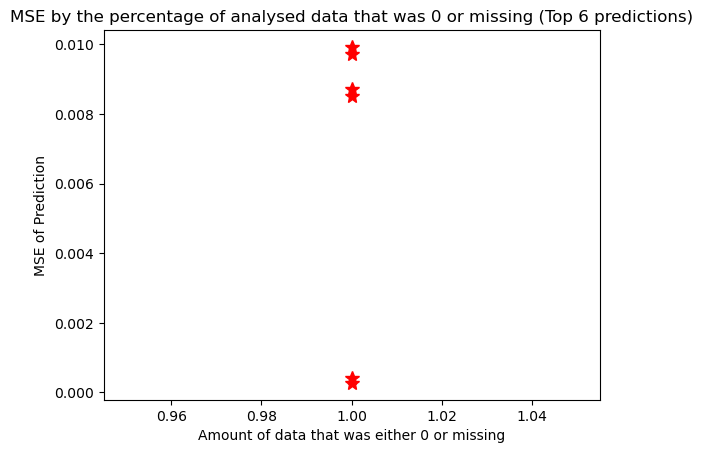

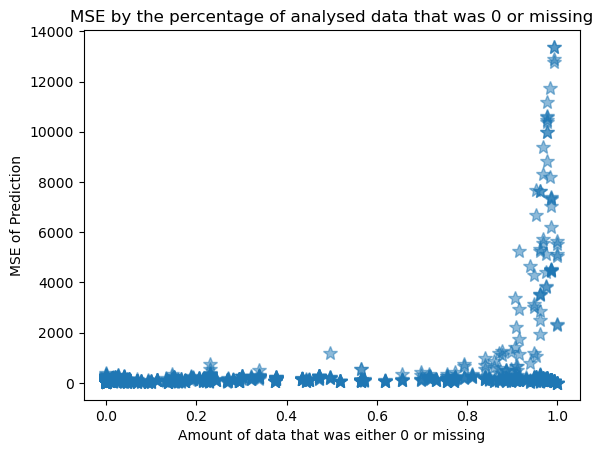

In [7]:
amount_of_zero_data = []
MSE_list = []
false_perfect_results = []
false_perfect_results_table = results_database.sort_values("MSE of prediction", ascending=True).head(6)
for iteration in range(len(results_database)):
    MSE = results_database['MSE of prediction'][iteration]
    MSE_list.append(MSE)
    actual_data = results_database['Actual Data'][iteration]
    zero_data_count = 0
    for point in actual_data:
        if point == 0:
            zero_data_count+= 1
    amount_of_zero_data.append(zero_data_count/len(results_database['Actual Data'][iteration]))
    for falsep in range(len(false_perfect_results_table)):
        if results_database['Game'][iteration] == np.array(false_perfect_results_table['Game'])[falsep]:
            if results_database['Type of search results file'][iteration] == np.array(false_perfect_results_table['Type of search results file'])[falsep]:
                if results_database['Distribution'][iteration] == np.array(false_perfect_results_table['Distribution'])[falsep]:
                    plt.plot(zero_data_count/len(results_database['Actual Data'][iteration]), MSE, 'r*', markersize = 10)

plt.xlabel("Amount of data that was either 0 or missing")
plt.ylabel("MSE of Prediction")
plt.title(f"MSE by the percentage of analysed data that was 0 or missing (Top 6 predictions)")
plt.show()

plt.plot(amount_of_zero_data,MSE_list,'*', markersize = 10, alpha = 0.5)
plt.xlabel("Amount of data that was either 0 or missing")
plt.ylabel("MSE of Prediction")
plt.title(f"MSE by the percentage of analysed data that was 0 or missing")
plt.show()


### The best model

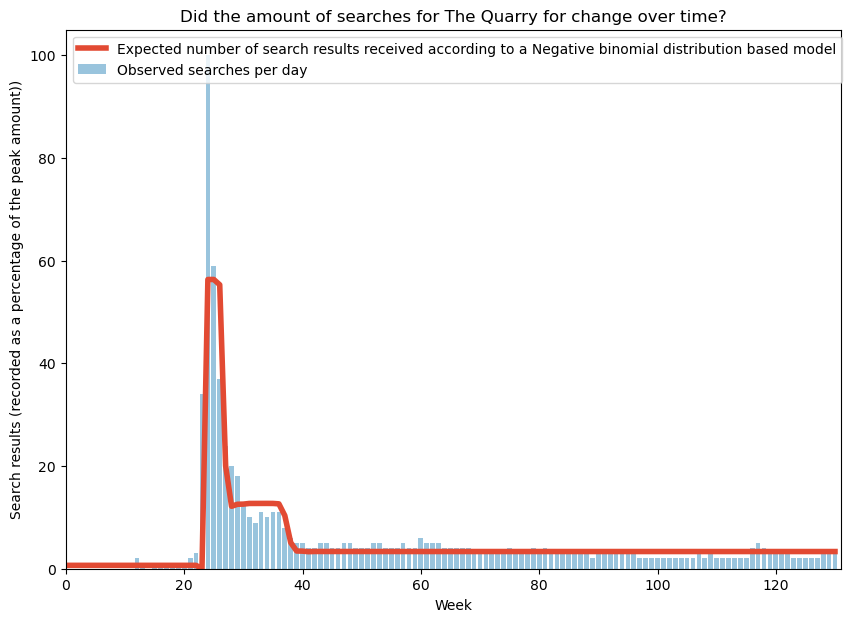

In [8]:
tablePrediction = np.array(best_10_predictions["Prediction"])
tableActualData = np.array(best_10_predictions["Actual Data"])
tableDistribution = np.array(best_10_predictions["Distribution"])
tableGame = np.array(best_10_predictions["Game"])
i=6
plt.rcParams['figure.figsize'] = [10, 7]
plt.bar(range(len(tableActualData[i])), tableActualData[i], color="#348ABD", alpha=0.5,
    label="Observed searches per day")
plt.xlabel("Week")
plt.ylabel("Search results (recorded as a percentage of the peak amount))")
plt.title(f"Did the amount of searches for {tableGame[i]} for change over time?")
plt.plot(range(len(tablePrediction[i])), tablePrediction[i], color="#E24A33", lw=4,
         label = f"Expected number of search results received according to a {tableDistribution[i]} based model")
plt.legend(loc="upper left")
plt.xlim(0, len(tableActualData[i]))
plt.show()

### The second-best model

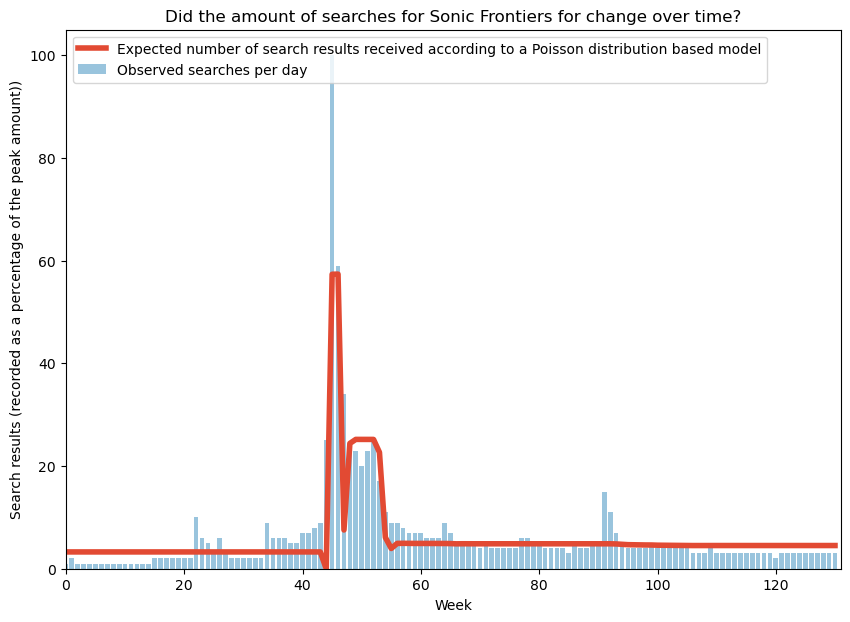

In [9]:
tablePrediction = np.array(best_10_predictions["Prediction"])
tableActualData = np.array(best_10_predictions["Actual Data"])
tableDistribution = np.array(best_10_predictions["Distribution"])
tableGame = np.array(best_10_predictions["Game"])
i=7
plt.rcParams['figure.figsize'] = [10, 7]
plt.bar(range(len(tableActualData[i])), tableActualData[i], color="#348ABD", alpha=0.5,
    label="Observed searches per day")
plt.xlabel("Week")
plt.ylabel("Search results (recorded as a percentage of the peak amount))")
plt.title(f"Did the amount of searches for {tableGame[i]} for change over time?")
plt.plot(range(len(tablePrediction[i])), tablePrediction[i], color="#E24A33", lw=4,
         label = f"Expected number of search results received according to a {tableDistribution[i]} based model")
plt.legend(loc="upper left")
plt.xlim(0, len(tableActualData[i]))
plt.show()

### The actual ten best predictions 

In [10]:
topten = results_database.sort_values("MSE of prediction", ascending=True)
topten.iloc[6:16]

,Year,Game,Type of search results file,Distribution,MSE of prediction,Actual Data,Prediction
613,2022,The Quarry,youtube searches.csv,Negative binomial distribution,27.990182,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, ...","[0.6582037459286264, 0.6582037459286264, 0.658..."
462,2022,Sonic Frontiers,web searches.csv,Poisson distribution,29.412171,"[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3.272368685971072, 3.272368685971072, 3.27236..."
355,2022,A Plague Tale Requiem,web searches.csv,Negative binomial distribution,29.590318,"[1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, ...","[1.9444681653539653, 1.9444681653539653, 1.944..."
464,2022,Sonic Frontiers,web searches.csv,Zero-inflated Poisson,30.175078,"[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3.2722679539313297, 3.2722679539313297, 3.272..."
265,2022,Pokémon Scarlet and Violet,web searches.csv,Negative binomial distribution,31.288123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, ...","[1.3320707420081108, 1.3320707420081108, 1.332..."
616,2022,The Quarry,youtube searches.csv,Binomial distribution,31.632002,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, ...","[0.6546339652423017, 0.6546339652423017, 0.654..."
103,2022,Saints Row,web searches.csv,Negative binomial distribution,31.981629,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2.123871865193861, 2.123871865193861, 2.12387..."
612,2022,The Quarry,youtube searches.csv,Poisson distribution,32.035752,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, ...","[0.6491924695466523, 0.6491924695466523, 0.649..."
550,2022,Stranger of Paradise Final Fantasy Origin,web searches.csv,Binomial distribution,32.335284,"[2, 3, 3, 2, 11, 5, 5, 8, 8, 12, 36, 100, 68, ...","[6.45529168071159, 6.45529168071159, 6.4552916..."
52,2022,Mario Strikers Battle League,web searches.csv,Binomial distribution,32.583740,"[0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 6, 4, 4, ...","[4.925087813911151, 4.925087813911151, 4.92508..."


### Utilising the ability to restrict the amount of time

In [11]:
import pymc as pm

/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_4250/3273703473.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_4250/1739598096.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))


0 : 13


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [tau_3]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 12 seconds.


13 : 26


/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_4250/1739598096.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [tau_3]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_4250/1739598096.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))


26 : 39


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [tau_3]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_4250/1739598096.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))


39 : 52


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [tau_3]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 19 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_4250/1739598096.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))


52 : 65


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [tau_3]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_4250/1739598096.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))


65 : 78


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [tau_3]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_4250/1739598096.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))


78 : 91


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [tau_3]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_4250/1739598096.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))


91 : 104


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [tau_3]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_4250/1739598096.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))


104 : 117


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [tau_3]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_4250/1739598096.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))


117 : 131


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [tau_3]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The Overall MSE is: 38.84267260780335


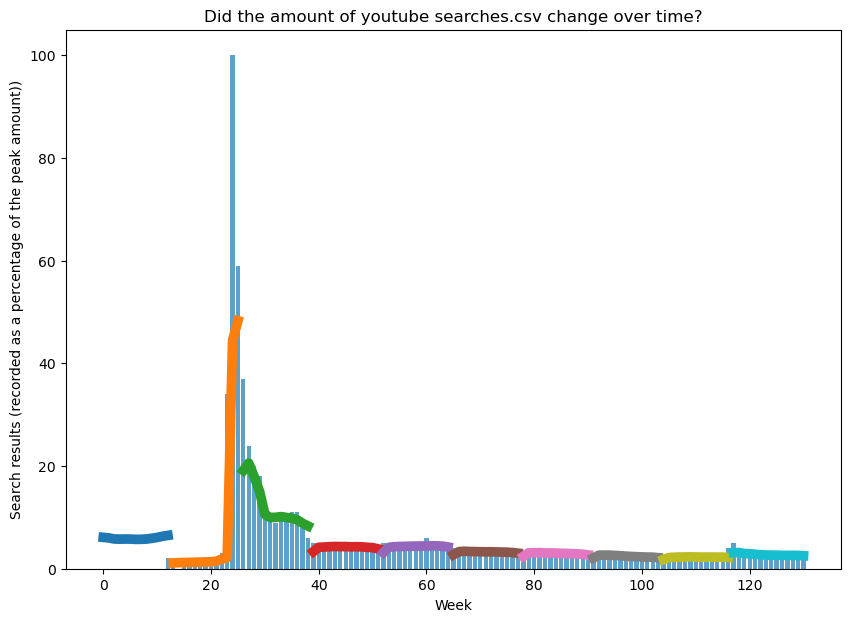

In [12]:
#Fix!!!!!!!!!!!!!!!!!!
os.chdir('/Users/elliotbarlow/Desktop/dissertation/data/2022/The Quarry')
file = 'youtube searches.csv'
oberservation_type = 'Negative binomial distribution'
data = pd.read_csv(file)
data2 = data.replace('<1',0.5).values[1:]
data3 = []
for i in data2[0 : -1]:
    data3.append(int(i))
    
MSE_total = 0
time = int(len(data3)/10)
    
plt.bar(np.arange(len(data3)), data3, color="#348ABD", alpha=0.8)
        
for step in range(10):
    startweek = step*time
    endweek = (step+1)*time
    if endweek == 130:
        endweek = endweek + 1
    print(startweek, ':', endweek)
    modelsection = changefinder(file, oberservation_type, startweek, endweek,)
    MSE_total += modelsection[0]
    plt.plot(np.arange(startweek,endweek), modelsection[1], linewidth=7.0)
plt.xlabel("Week")
plt.ylabel("Search results (recorded as a percentage of the peak amount))")
plt.title(f"Did the amount of {file} change over time?")
print("The Overall MSE is:", MSE_total/10)              
os.chdir('/Users/elliotbarlow/Desktop/dissertation')


In [13]:
sucessful = topten.loc[ (topten['MSE of prediction']>5) & (results_database['MSE of prediction']<=250) ]
sucessful = sucessful.loc[ sucessful['MSE of prediction']>5 ]
print('Overall sucess rate is (in reliable range):', 100*( len(sucessful)/len(results_database) ) )
print("(However, all 100% of the files ran.)")

Overall sucess rate is (in reliable range): 88.20301783264746
(However, all 100% of the files ran.)


## How each type of search reult data compares to eachother

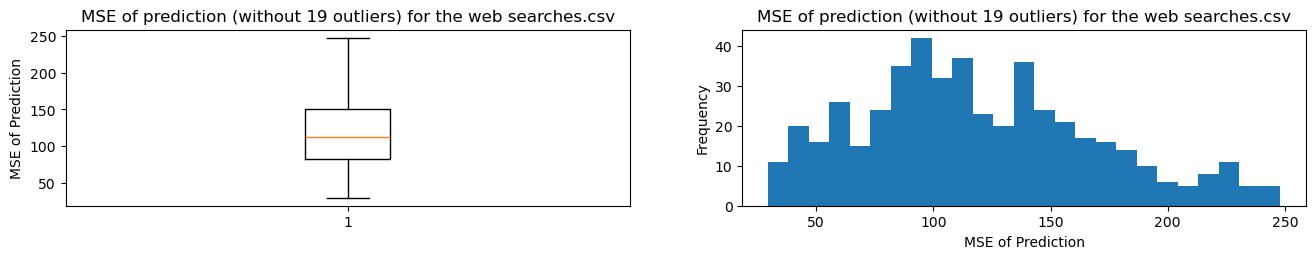

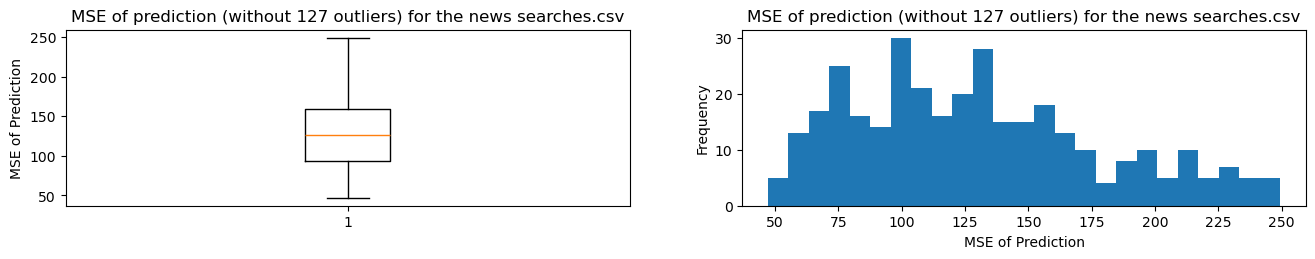

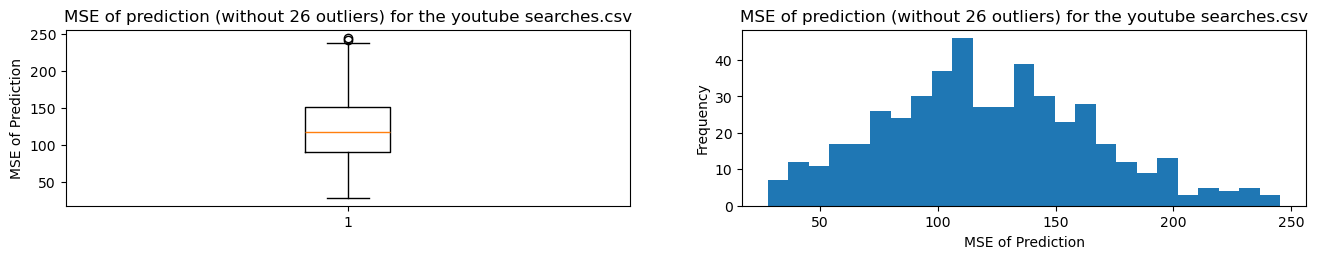

In [14]:
annomali = []
average_mse = []
min_for_type = []
searchlist = ['web searches.csv', 'news searches.csv', 'youtube searches.csv']
for searchtype in searchlist:
    if searchtype == searchlist[1]:
        i = 1
        j = 10
    if searchtype == searchlist[2]:
        i = 2
        j = 20
    else:
        i = 0
        j = 0
        
    data = results_database.loc[ (results_database['Type of search results file'] == searchtype) ] 
    data2 = results_database.loc[ (results_database['Type of search results file'] == searchtype) & (results_database['MSE of prediction']<=250) ]
    data_filtered = data2.loc[ data2['MSE of prediction']>5 ]
    place1 = 621+i
    place2 = 622+i
    plt.figure(figsize = [16,16])
    plt.subplot(place1)
    plt.boxplot(data_filtered['MSE of prediction'])
    plt.ylabel('MSE of Prediction')
    plt.title(f"MSE of prediction (without {len(data)- len(data_filtered)} outliers) for the {searchtype}")

    plt.subplot(place2)
    plt.hist(data_filtered['MSE of prediction'], bins=25)
    plt.xlabel('MSE of Prediction')
    plt.ylabel('Frequency')
    plt.title(f"MSE of prediction (without {len(data)- len(data_filtered)} outliers) for the {searchtype}")
    
    plt.show()
    annomali.append([f"The {searchtype} had", {len(data)- len(data_filtered)}, 'potential errors occur'])
    average_mse.append([f"The {searchtype} had and average MSE of", {np.mean(data_filtered['MSE of prediction'])}])
    min_for_type.append([f"The {searchtype} had and minimum MSE of", {np.min(data_filtered['MSE of prediction'])}])
    print()
    print()
    print()

In [15]:
annomali

[['The web searches.csv had', {19}, 'potential errors occur'],
 ['The news searches.csv had', {127}, 'potential errors occur'],
 ['The youtube searches.csv had', {26}, 'potential errors occur']]

In [16]:
average_mse

[['The web searches.csv had and average MSE of', {118.89768754794584}],
 ['The news searches.csv had and average MSE of', {129.56753520183688}],
 ['The youtube searches.csv had and average MSE of', {121.42722761233236}]]

In [17]:
min_for_type

[['The web searches.csv had and minimum MSE of', {29.412170893626847}],
 ['The news searches.csv had and minimum MSE of', {47.17608295468022}],
 ['The youtube searches.csv had and minimum MSE of', {27.99018240733848}]]

## Analysis of the different distributions

In [18]:
distributionlist = ["Poisson distribution", "Negative binomial distribution", "Zero-inflated Poisson", "Normal dististribution", "Binomial distribution",
                    "T Student distribution"]

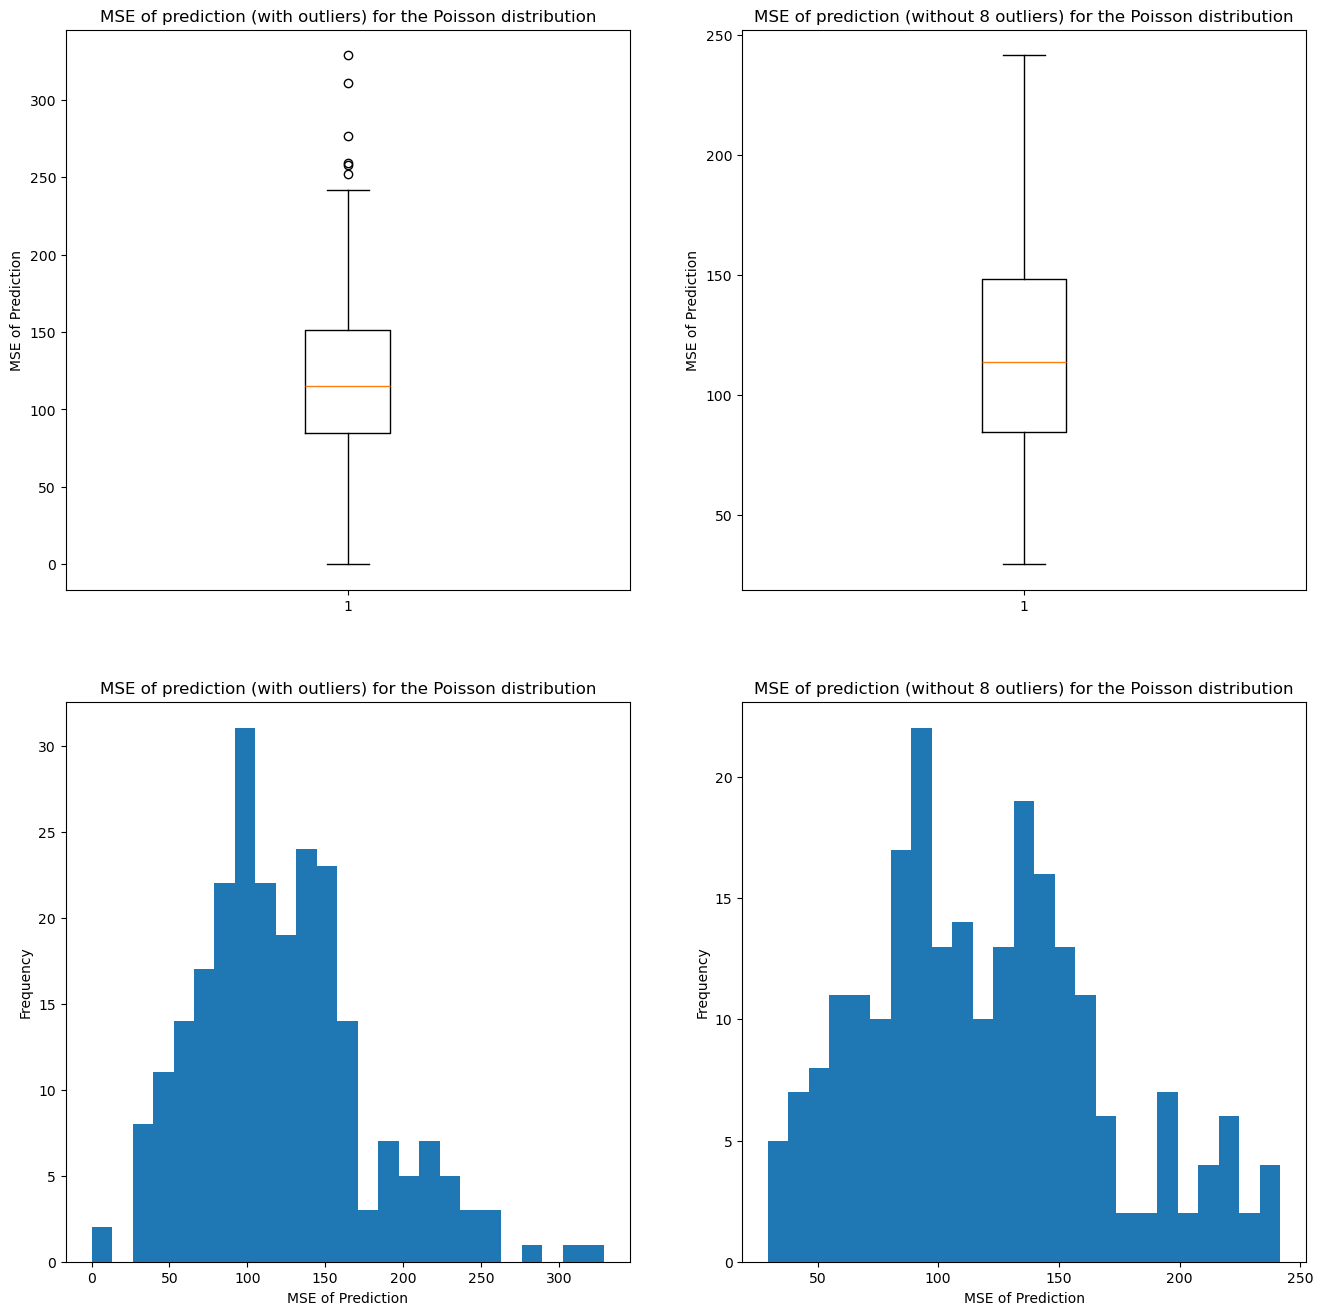

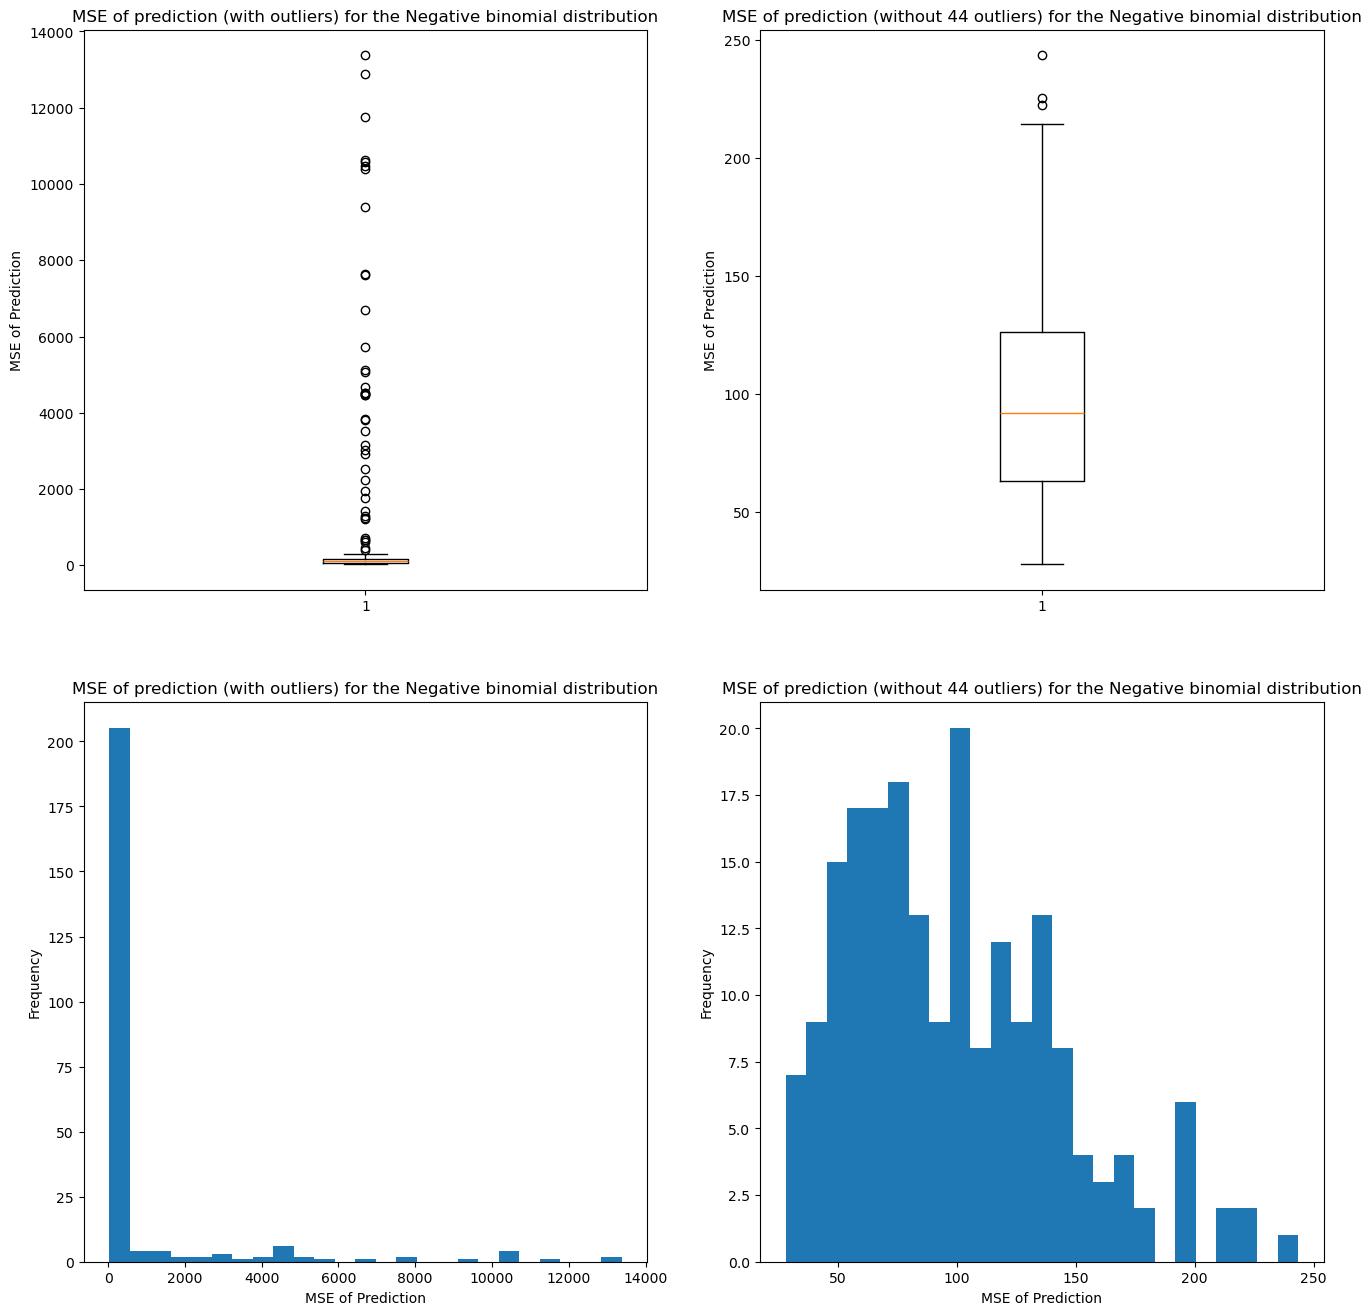

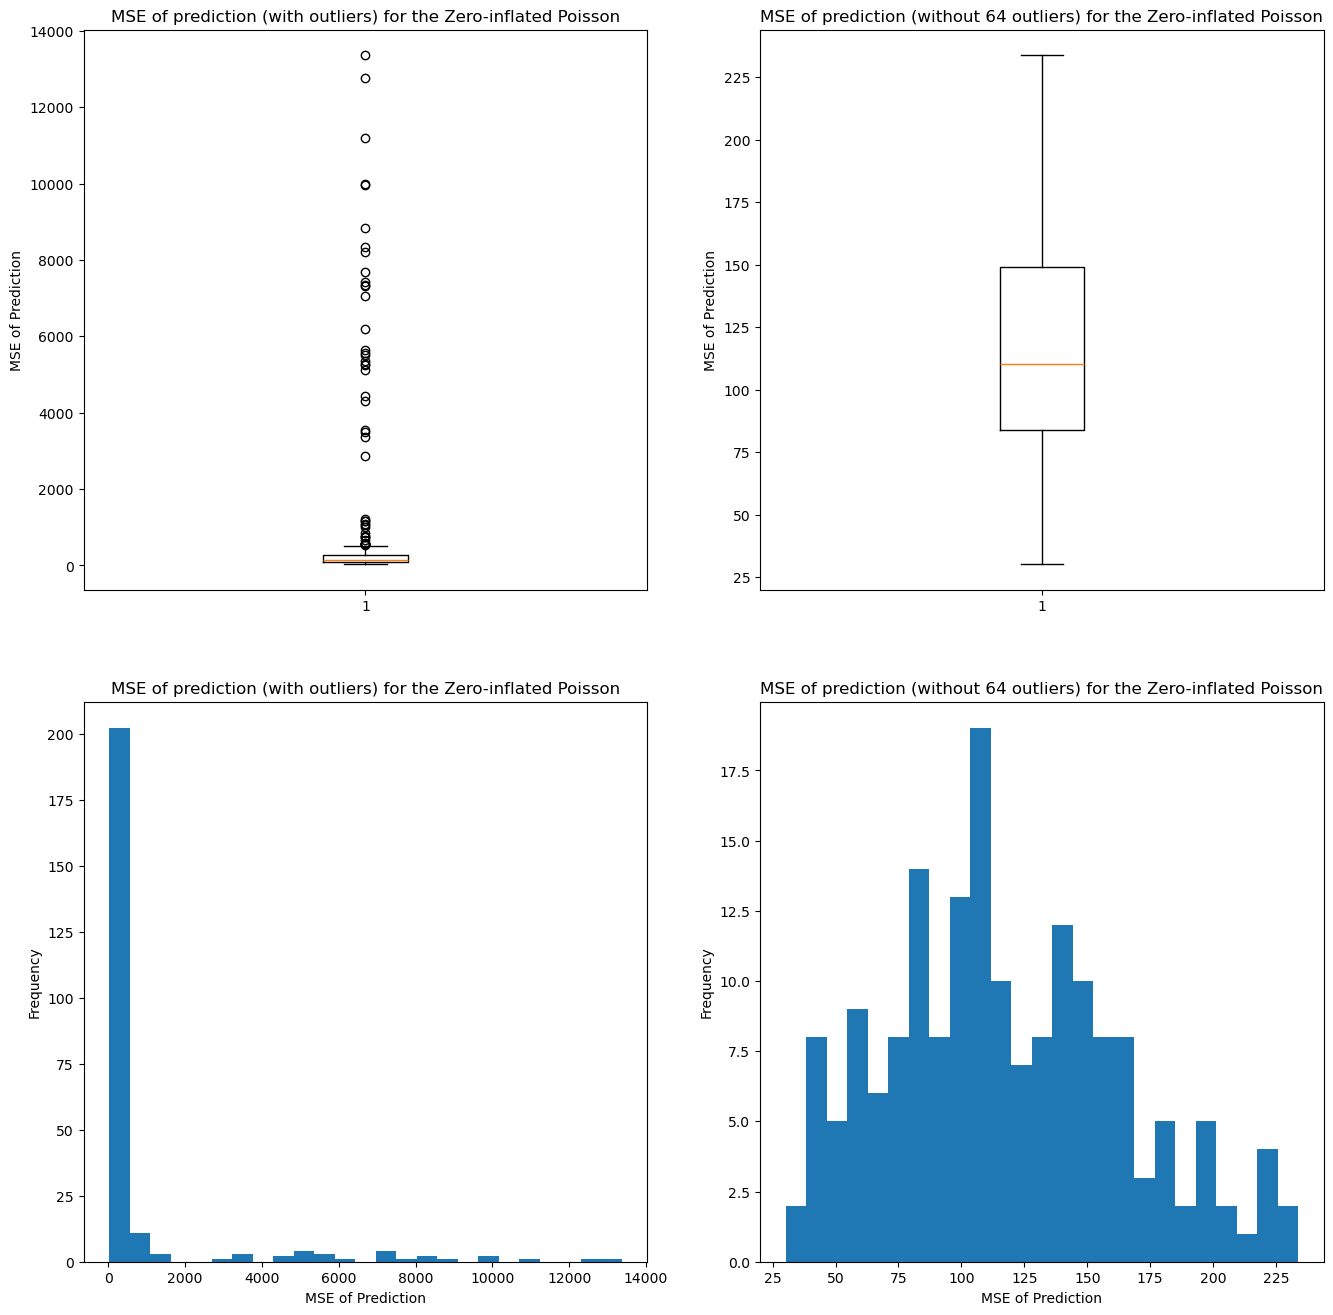

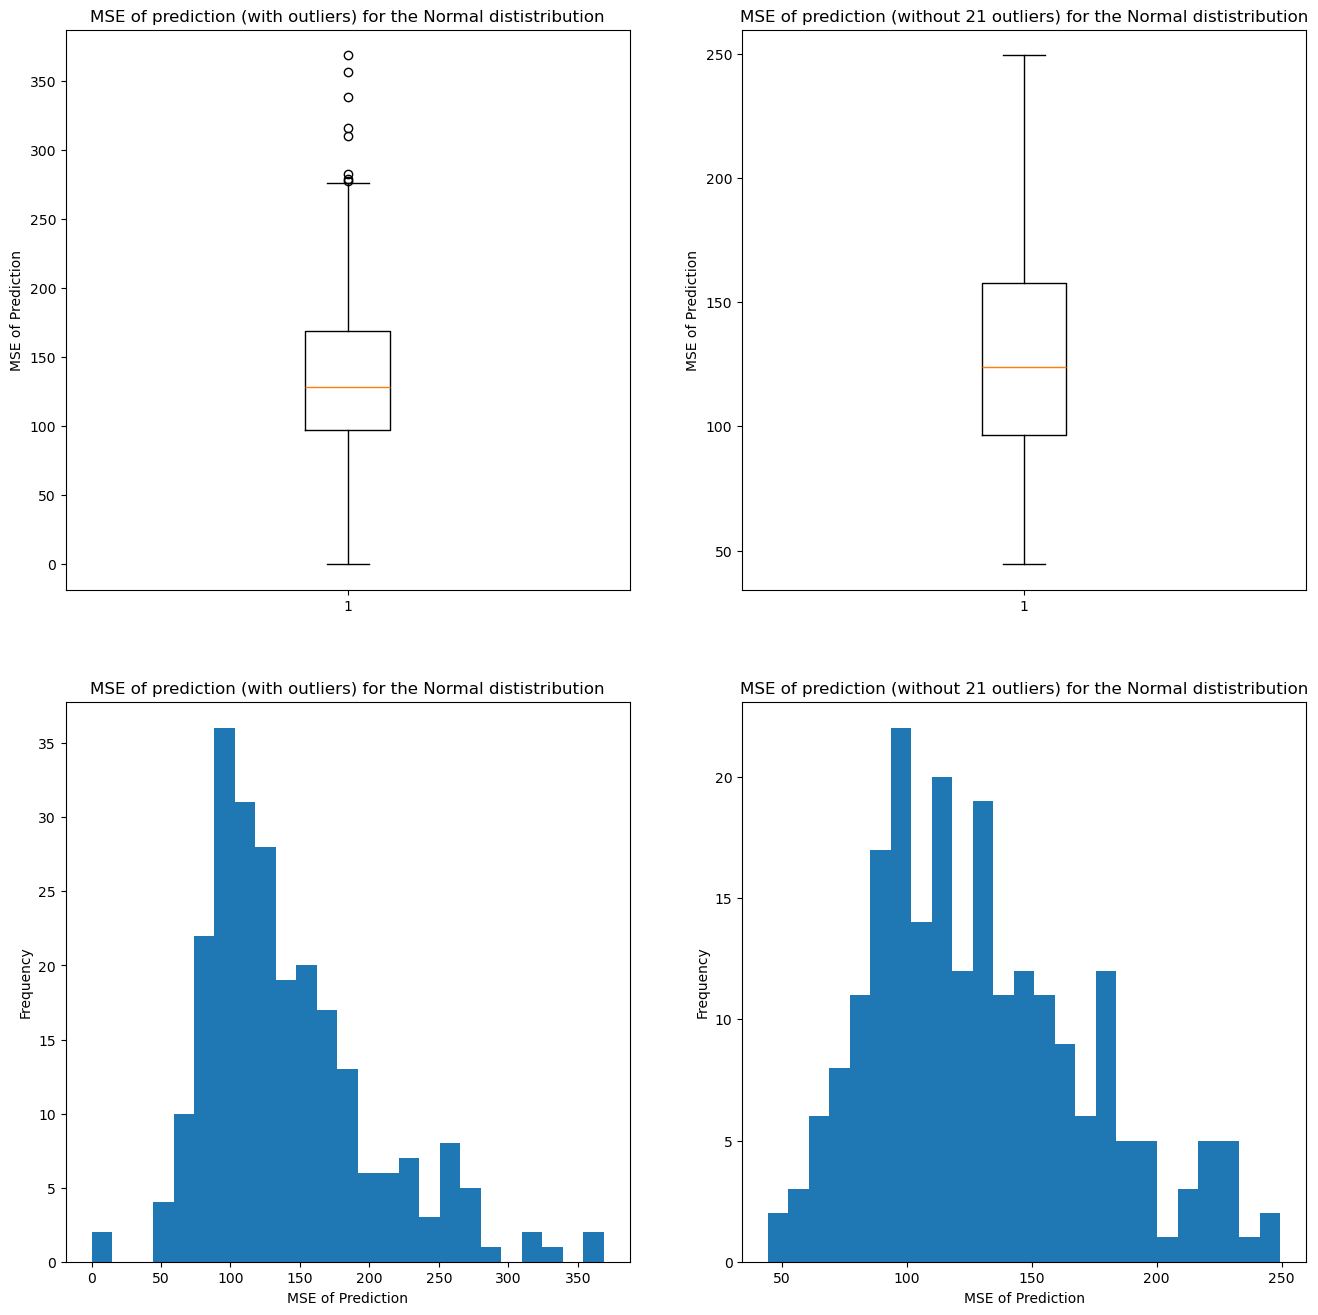

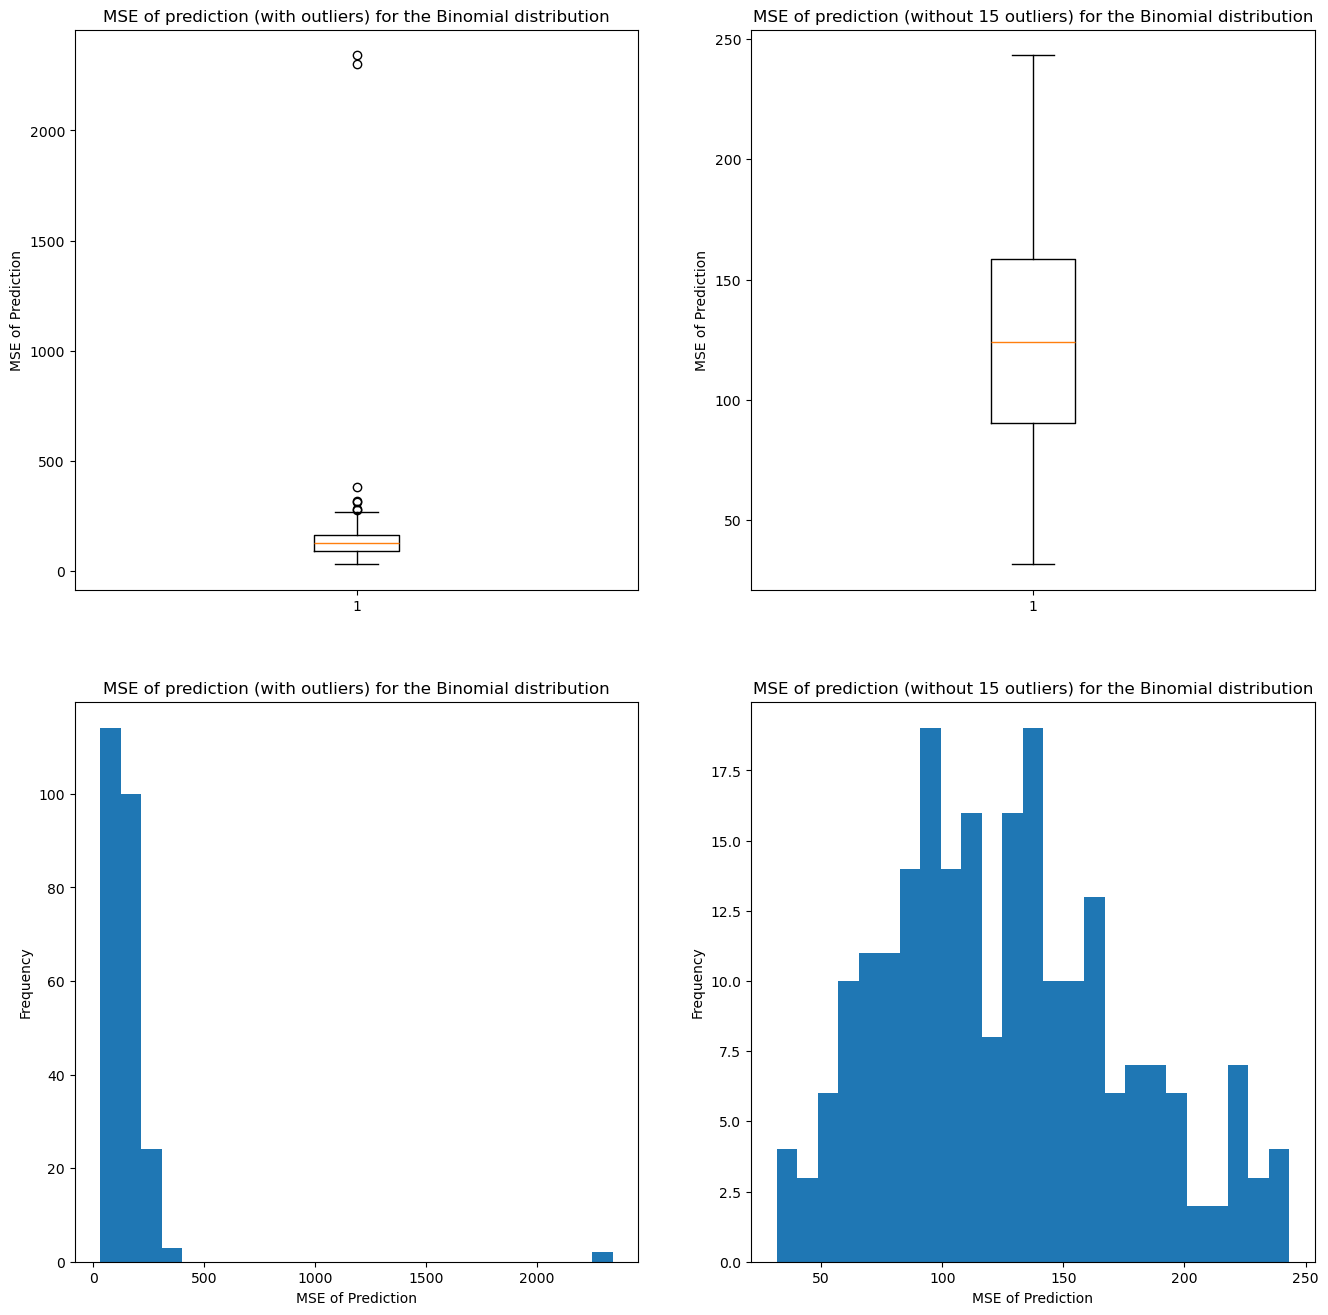

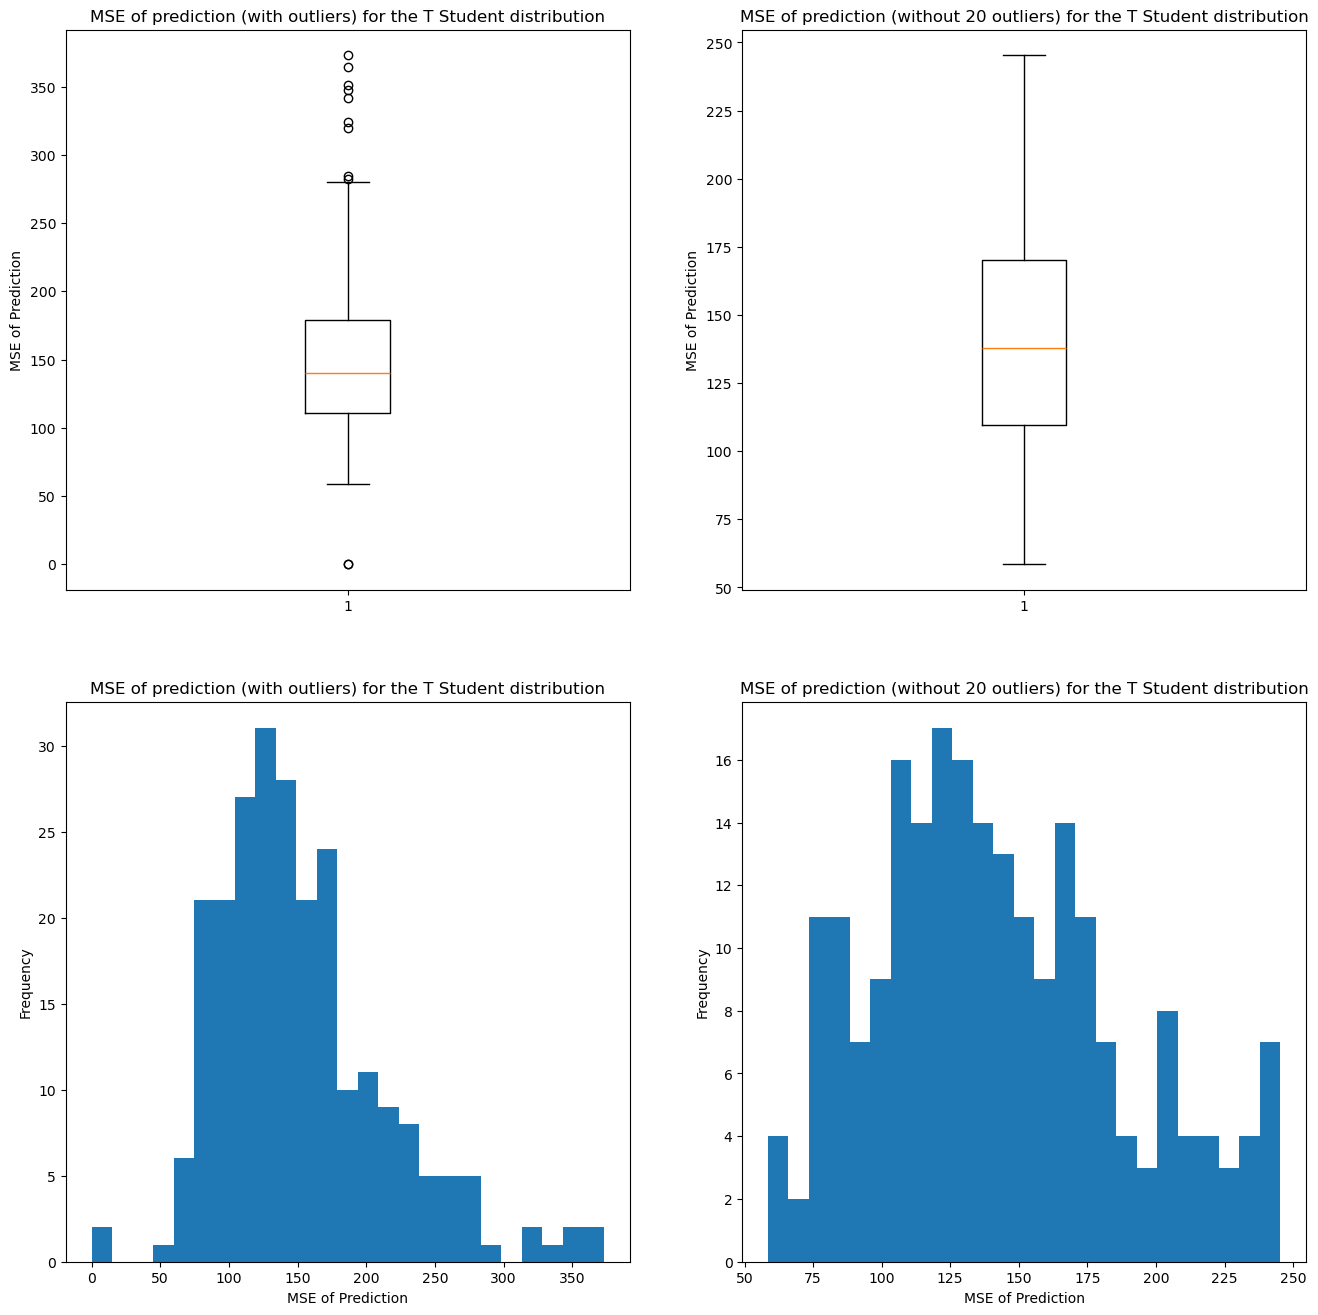

In [36]:
annomalilist = []
average_mse_for_distribution = []
min_for_distribution = []
for dist in distributionlist:
    
    data = results_database.loc[ (results_database['Distribution'] == dist) ] 
    data2 = results_database.loc[ (results_database['Distribution'] == dist) & (results_database['MSE of prediction']<=250) ]
    data_filtered = data2.loc[ data2['MSE of prediction']>5 ]
    plt.figure(figsize = [16,16])
    plt.subplot(221)
    plt.boxplot(data['MSE of prediction'])
    plt.ylabel('MSE of Prediction')
    plt.title(f"MSE of prediction (with outliers) for the {dist}")
    
    
    plt.subplot(222)
    plt.boxplot(data_filtered['MSE of prediction'])
    plt.ylabel('MSE of Prediction')
    plt.title(f"MSE of prediction (without {len(data)- len(data_filtered)} outliers) for the {dist}")
    
    
    plt.subplot(223)
    plt.hist(data['MSE of prediction'], bins=25)
    plt.xlabel('MSE of Prediction')
    plt.ylabel('Frequency')
    plt.title(f"MSE of prediction (with outliers) for the {dist}")
    
    plt.subplot(224)
    plt.hist(data_filtered['MSE of prediction'], bins=25)
    plt.xlabel('MSE of Prediction')
    plt.ylabel('Frequency')
    plt.title(f"MSE of prediction (without {len(data)- len(data_filtered)} outliers) for the {dist}")

    plt.savefig(f'{dist} appendix 4.png')
    plt.show()
    annomalilist.append([f"The {dist} had", {len(data)- len(data_filtered)}, 'potential errors occur'])
    average_mse_for_distribution.append([f"The {dist} had and average MSE of", {np.mean(data_filtered['MSE of prediction'])}])
    min_for_distribution.append([f"The {dist} had and minimum MSE of", {np.min(data_filtered['MSE of prediction'])}])
    
    print()
    print()
    print()

In [20]:
annomalilist

[['The Poisson distribution had', {8}, 'potential errors occur'],
 ['The Negative binomial distribution had', {44}, 'potential errors occur'],
 ['The Zero-inflated Poisson had', {64}, 'potential errors occur'],
 ['The Normal dististribution had', {21}, 'potential errors occur'],
 ['The Binomial distribution had', {15}, 'potential errors occur'],
 ['The T Student distribution had', {20}, 'potential errors occur']]

In [21]:
average_mse_for_distribution

[['The Poisson distribution had and average MSE of', {118.90509280861616}],
 ['The Negative binomial distribution had and average MSE of',
  {98.28065555323624}],
 ['The Zero-inflated Poisson had and average MSE of', {117.30716408594203}],
 ['The Normal dististribution had and average MSE of', {130.35341504239568}],
 ['The Binomial distribution had and average MSE of', {125.50445979117676}],
 ['The T Student distribution had and average MSE of', {141.7881769183843}]]

In [22]:
min_for_distribution

[['The Poisson distribution had and minimum MSE of', {29.412170893626847}],
 ['The Negative binomial distribution had and minimum MSE of',
  {27.99018240733848}],
 ['The Zero-inflated Poisson had and minimum MSE of', {30.175077782562173}],
 ['The Normal dististribution had and minimum MSE of', {44.48404950935477}],
 ['The Binomial distribution had and minimum MSE of', {31.632002230314285}],
 ['The T Student distribution had and minimum MSE of', {58.52178937303673}]]

# Method 2

In [23]:
def exponentialdecaymodel(file, startweek = 0, endweek = -1):
    if file is None:
        data2 = [50]*100 +[25]*100 + [75]*100 +[100]*100
        data2 = [50]*100
    else:
        data = pd.read_csv(file)
    
        data2 = data.replace('<1',0.5).values[1:]
        #data2 = data2.replace(0,0.5).values[1:]
    data3 = []

    for i in data2[startweek : endweek]:
        data3.append(float(i))
    values = np.array(data3) #count_data in the book
    weeks = len(values) #n_count_data in the book
    alpha = 1.0 / weeks
    
    with pm.Model() as model:
        a1 = pm.Exponential("a1", 2/np.max(values[0:int(len(values)/4)]) )#, sigma = np.std(values))
        a2 = pm.Exponential("a2", 2/np.max(values[int(len(values)/4):int(len(values)/2)]) )#, sigma = np.std(values))
        a3 = pm.Exponential("a3", 2/np.max(values[int(len(values)/2):int(3*len(values)/4)]) )#, sigma = np.std(values))
        a4 = pm.Exponential("a4", 2/np.max(values[int(3*len(values)/4):]) )#, sigma = np.std(values))
        
        #Period one: 0-Tau: lambda_1
        lambda_1 = pm.Normal("lambda_1", mu = 0, sigma = 0.5)
        #Period two: Tau-Tau_2: lambda_2
        lambda_2 = pm.Normal("lambda_2", mu = 0, sigma = 0.5)
        #Period three: Tau_2-Tau_3: lambda_3
        lambda_3 = pm.Normal("lambda_3", mu = 0, sigma = 0.5)
        #Period four: Tau_3-End: lambda_4
        lambda_4 = pm.Normal("lambda_4", mu = 0, sigma = 0.5)
        
        tau_2 = pm.Uniform("tau_2", lower = 0, upper = weeks)
        tau_3 = pm.Uniform("tau_3", lower = tau_2, upper = weeks)
        tau = pm.Uniform("tau", lower = 0, upper = tau_2) 
        
        weekssubtrcattau = pm.Deterministic('weekssubtrcattau', weeks - tau)
        weekssubtrcattau2 = pm.Deterministic('weekssubtrcattau2', weeks - tau_2)
        weekssubtrcattau3 = pm.Deterministic('weekssubtrcattau3', weeks - tau_3)

        
        idx = np.arange(weeks) # Index
        lambda_ = pm.math.switch(idx < tau, lambda_1,
                                 pm.math.switch(idx < tau_2, lambda_2, 
                                                pm.math.switch(idx < tau_3, lambda_3, lambda_4)))
        
        amplitude_ = pm.math.switch(idx < tau, a1,
                                 pm.math.switch(idx < tau_2, a2, 
                                                pm.math.switch(idx < tau_3, a3, a4)))
        weeks_ = pm.math.switch(idx < tau, weeks,
                                 pm.math.switch(idx < tau_2, weekssubtrcattau , 
                                                pm.math.switch(idx < tau_3, weekssubtrcattau2, weekssubtrcattau3)))
        
        rate = my_exponential(weeks_, amplitude_, lambda_, 0, 0) 
        observation = pm.Poisson("obs", rate, observed=values)
        
        step = pm.Metropolis()
        trace = pm.sample(50000, tune = 10000, step = step, return_inferencedata = False)
        
    a1samples = trace['a1']
    a2samples = trace['a2']
    a3samples = trace['a3']
    a4samples = trace['a4']
    
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    lambda_3_samples = trace['lambda_3']
    lambda_4_samples = trace['lambda_4']
    
    tau_samples = trace['tau']
    tau_2_samples = trace['tau_2']
    tau_3_samples = trace['tau_3']

    expected_texts_per_day = np.zeros(weeks)
    N = tau_samples.shape[0]
    for day in range(0, weeks):
        ix_1 = day < tau_samples
        
        ix2_upperbound = (day < tau_2_samples)
        ix2_lowerbound = (day > tau_samples)
        ix_2 = np.logical_and(ix2_upperbound, ix2_lowerbound)

        ix3_upperbound = (day < tau_3_samples)
        ix3_lowerbound = (day > tau_2_samples)
        ix_3 = np.logical_and(ix3_upperbound, ix3_lowerbound)

        ix_4 = day > tau_3_samples

        mean1 = 0
        mean2 = 0
        mean3 = 0
        mean4 = 0
        if np.sum(ix_1)>0:
            mean1 = np.mean(my_exponential(day, (a1samples[ix_1]),(lambda_1_samples[ix_1]),0,0) )
        if np.sum(ix_2)>0:
            mean2 = np.mean(my_exponential((day -  tau_samples)[ix_2], (a2samples[ix_2]),(lambda_2_samples[ix_2]),0,0) )
        if np.sum(ix_3)>0:
            mean3 = np.mean(my_exponential((day - tau_2_samples)[ix_3], (a3samples[ix_3]),(lambda_3_samples[ix_3]),0,0) )
        if np.sum(ix_4)>0:
            mean4 = np.mean(my_exponential((day - tau_3_samples)[ix_4], (a4samples[ix_4]),(lambda_4_samples[ix_4]),0,0) )
        expected_texts_per_day[day] = (mean1 + mean2 + mean3 + mean4)
    
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.plot(range(weeks), expected_texts_per_day, color="#E24A33", lw=4,
             label = f"Expected number of search results received according to an exponential decay based model")
    
    if endweek == -1:
        plt.xlim(startweek, weeks)
    else:
        plt.xlim(startweek, endweek)
    plt.bar(np.arange(weeks), values, color="#348ABD", alpha=0.5,
            label="Observed searches per day")
    name = file
    plt.xlabel("Week")
    plt.ylabel("Search results (recorded as a percentage of the peak amount))")
    plt.title(f"Did the amount of {file} change over time?")
    
    mplot=10000
    for j in range(mplot):
        i = int((N/mplot)*j)
        expected_texts_per_day_i = np.zeros(weeks)
        a1samples = trace['a1'][i:i+1]
        a2samples = trace['a2'][i:i+1]
        a3samples = trace['a3'][i:i+1]
        a4samples = trace['a4'][i:i+1]
        
        lambda_1_samples = trace['lambda_1'][i:i+1]
        lambda_2_samples = trace['lambda_2'][i:i+1]
        lambda_3_samples = trace['lambda_3'][i:i+1]
        lambda_4_samples = trace['lambda_4'][i:i+1]
        
        tau_samples = trace['tau'][i:i+1]
        tau_2_samples = trace['tau_2'][i:i+1]
        tau_3_samples = trace['tau_3'][i:i+1]
        for day in range(0, weeks):
            ix_1 = day < tau_samples
            
            ix2_upperbound = (day < tau_2_samples)
            ix2_lowerbound = (day > tau_samples)
            ix_2 = np.logical_and(ix2_upperbound, ix2_lowerbound)
    
            ix3_upperbound = (day < tau_3_samples)
            ix3_lowerbound = (day > tau_2_samples)
            ix_3 = np.logical_and(ix3_upperbound, ix3_lowerbound)
    
            ix_4 = day > tau_3_samples
    
            mean1 = 0
            mean2 = 0
            mean3 = 0
            mean4 = 0
            if np.sum(ix_1)>0:
                mean1 = np.mean(my_exponential(day, (a1samples[ix_1]),(lambda_1_samples[ix_1]),0,0) )
            if np.sum(ix_2)>0:
                mean2 = np.mean(my_exponential((day -  tau_samples)[ix_2], (a2samples[ix_2]),(lambda_2_samples[ix_2]),0,0) )
            if np.sum(ix_3)>0:
                mean3 = np.mean(my_exponential((day - tau_2_samples)[ix_3], (a3samples[ix_3]),(lambda_3_samples[ix_3]),0,0) )
            if np.sum(ix_4)>0:
                mean4 = np.mean(my_exponential((day - tau_3_samples)[ix_4], (a4samples[ix_4]),(lambda_4_samples[ix_4]),0,0) )
            expected_texts_per_day_i[day] = (mean1 + mean2 + mean3 + mean4)
            
        plt.plot(range(weeks), expected_texts_per_day_i, 'g--', lw=1, alpha=0.01)
        
    plt.legend(loc="upper left")
    plt.ylim(0,100)
    plt.show()
    differences = ( np.array(expected_texts_per_day) - np.array(values) )**2
    MSE = ( sum(differences)/len(values) )
    print('The MSE is:', MSE)

In [24]:
with open("results for method 2.obj", "rb") as filehandler:
    second_results_table = pickle.load(filehandler)

second_results_database =  pd.DataFrame(second_results_table, columns=['Year', 'Game', 'Type of search results file', 'MSE of prediction', 'Actual Data', 'Prediction'])
second_results_database


,Year,Game,Type of search results file,MSE of prediction,Actual Data,Prediction
0,2022,Pokemon Legends Arceus,news searches.csv,108.426489,"[14.0, 21.0, 27.0, 50.0, 89.0, 100.0, 63.0, 46...","[53.42371594290385, 53.19871964036308, 52.9764..."
1,2022,Pokemon Legends Arceus,youtube searches.csv,129.938884,"[5.0, 10.0, 13.0, 26.0, 79.0, 100.0, 70.0, 54....","[43.26485764517558, 43.11212606768928, 42.9615..."
2,2022,Pokemon Legends Arceus,web searches.csv,219.470571,"[3.0, 5.0, 6.0, 13.0, 51.0, 100.0, 69.0, 55.0,...","[63.80999711423057, 63.368106555693856, 62.931..."
3,2022,NBA 2K23,youtube searches.csv,589.530747,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0083034280815608, 1.0033418782504178, 0.998..."
4,2022,NBA 2K23,web searches.csv,1184.919819,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.9149020402176833, 1.8824473535916242, 1.850..."
...,...,...,...,...,...,...
170,2023,Baldur's Gate 3,web searches.csv,216.732867,"[1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, ...","[0.5160768545915525, 0.5152795222716032, 0.514..."
171,2023,Atomic Heart,youtube searches.csv,344.392929,"[2.0, 4.0, 5.0, 4.0, 5.0, 7.0, 9.0, 100.0, 72....","[53.08883710489019, 51.95767903736884, 50.8608..."
172,2023,Atomic Heart,web searches.csv,241.914335,"[2.0, 6.0, 5.0, 3.0, 4.0, 6.0, 9.0, 100.0, 50....","[48.48328568508757, 47.20530096830058, 45.9700..."
173,2023,Remnant 2,youtube searches.csv,130.354799,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.4977457195903879, 0.4969066975029383, 0.496..."


In [25]:
failed_to_run = [[2022, 'NBA 2K23', 'news searches.csv'], [2022, 'Mario Strikers Battle League', 'news searches.csv'], [2022, 'Tunic', 'news searches.csv'], [2022, 'Saints Row', 'news searches.csv'], [2022, "Marvel's Midnight Suns", 'news searches.csv'], [2022, 'Nobody Saves the World', 'news searches.csv'], [2022, 'Gotham Knights', 'news searches.csv'], [2022, 'Disney Dreamlight Valley', 'news searches.csv'], [2022, 'Trek to Yomi', 'news searches.csv'], [2022, 'The Callisto Protocol', 'news searches.csv'], [2022, 'Ghostwire Tokyo', 'news searches.csv'], [2022, 'Kirby and the Forgotten Land', 'news searches.csv'], [2022, 'A Plague Tale Requiem', 'news searches.csv'], [2022, 'Cuphead The Delicious Last Course', 'news searches.csv'], [2022, 'Cult of the Lamb', 'news searches.csv'], [2022, 'Mario + Rabbids Sparks of Hope', 'news searches.csv'], [2022, 'Xenoblade Chronicles 3', 'news searches.csv'], [2022, 'OlliOlli World', 'news searches.csv'], [2022, 'OlliOlli World', 'youtube searches.csv'], [2022, 'OlliOlli World', 'web searches.csv'], [2022, 'Evil Dead The Game', 'news searches.csv'], [2022, 'Stranger of Paradise Final Fantasy Origin', 'news searches.csv'], [2022, "Tiny Tina's Wonderlands", 'news searches.csv'], [2022, 'F1 22', 'news searches.csv'], [2022, 'The Quarry', 'news searches.csv'], [2022, 'WWE 2K22', 'news searches.csv'], [2023, 'Payday 3', 'youtube searches.csv'], [2023, 'Payday 3', 'web searches.csv'], [2023, 'Pikmin 4', 'news searches.csv'], [2023, 'Hi-Fi Rush', 'news searches.csv'], [2023, 'Advance Wars 1+2 Re-Boot Camp', 'news searches.csv'], [2023, 'Redfall', 'news searches.csv'], [2023, 'Wild Hearts', 'news searches.csv'], [2023, "Kirby's Return to Dream Land Deluxe", 'news searches.csv'], [2023, "Kirby's Return to Dream Land Deluxe", 'youtube searches.csv'], [2023, 'Minecraft Legends', 'news searches.csv'], [2023, 'Company of Heroes 3', 'news searches.csv'], [2023, 'Fire Emblem Engage', 'news searches.csv'], [2023, 'ARMORED CORE™ VI FIRES OF RUBICON™', 'news searches.csv'], [2023, 'ARMORED CORE™ VI FIRES OF RUBICON™', 'youtube searches.csv'], [2023, 'ARMORED CORE™ VI FIRES OF RUBICON™', 'web searches.csv'], [2023, 'Immortals of Aveum', 'news searches.csv'], [2023, 'Alan Wake 2', 'news searches.csv'], [2023, 'Avatar Frontiers of Pandora', 'news searches.csv'], [2023, 'Forspoken', 'news searches.csv'], [2023, 'Super Mario Bros. Wonder', 'news searches.csv'], [2023, 'Super Mario Bros. Wonder', 'youtube searches.csv'], [2023, 'Super Mario Bros. Wonder', 'web searches.csv'], [2023, 'Crime Boss Rockay City', 'news searches.csv'], [2023, 'Crime Boss Rockay City', 'youtube searches.csv'], [2023, 'Crime Boss Rockay City', 'web searches.csv'], [2023, 'Sea of Stars', 'news searches.csv'], [2023, 'Sea of Stars', 'youtube searches.csv'], [2023, 'Sea of Stars', 'web searches.csv'], [2023, "Marvel's Spider-Man 2", 'news searches.csv'], [2023, "Marvel's Spider-Man 2", 'youtube searches.csv'], [2023, "Marvel's Spider-Man 2", 'web searches.csv'], [2023, 'Dredge', 'news searches.csv'], [2023, 'One Piece Odyssey', 'news searches.csv'], [2023, 'Dead Space', 'news searches.csv'], [2023, 'Metroid Prime Remastered', 'news searches.csv'], [2023, 'Wo Long Fallen Dynasty', 'news searches.csv'], [2023, 'OCTOPATH TRAVELER II', 'news searches.csv'], [2023, 'Atomic Heart', 'news searches.csv'], [2023, 'Remnant 2', 'news searches.csv'], [2023, 'Mortal Kombat 1', 'news searches.csv'], [2023, 'Mortal Kombat 1', 'youtube searches.csv'], [2023, 'Mortal Kombat 1', 'web searches.csv']]
failed_database = pd.DataFrame(failed_to_run, columns = ['Year', 'Game', 'Type of search results file'])
failed_database
for type in ['web searches.csv', 'news searches.csv', 'youtube searches.csv']:
    print(type, "failed to run", len(failed_database.loc[ (failed_database['Type of search results file'] == type) ]), 'times' ) 




web searches.csv failed to run 8 times
news searches.csv failed to run 51 times
youtube searches.csv failed to run 9 times


In [26]:
print( "Sucessful run rate:", 100*(1 - len(failed_database) / ( len(second_results_database) + len(failed_database) ) ), '%' )

Sucessful run rate: 72.01646090534979 %


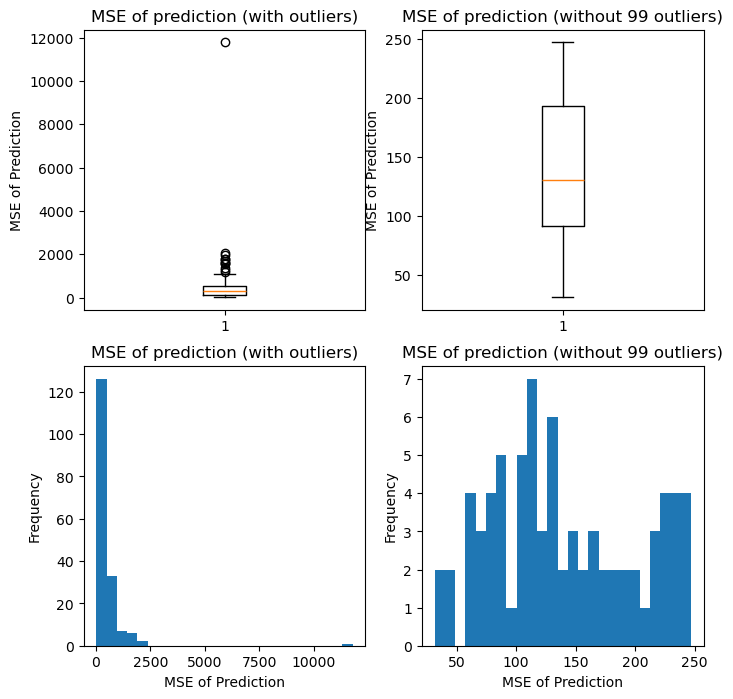

In [27]:
MSE_results2 = np.array(second_results_database['MSE of prediction'])
MSE_results_filtered2 = np.array(second_results_database['MSE of prediction'][second_results_database['MSE of prediction']<=250 ])
plt.figure(figsize = [8,8])
plt.subplot(221)
plt.boxplot(MSE_results2)
plt.ylabel('MSE of Prediction')
plt.title("MSE of prediction (with outliers)")


plt.subplot(222)
plt.boxplot(MSE_results_filtered2)
plt.ylabel('MSE of Prediction')
plt.title(f"MSE of prediction (without {len(MSE_results2)- len(MSE_results_filtered2)} outliers)")


plt.subplot(223)
plt.hist(MSE_results2, bins=25)
plt.xlabel('MSE of Prediction')
plt.ylabel('Frequency')
plt.title("MSE of prediction (with outliers)")

plt.subplot(224)
plt.hist(MSE_results_filtered2, bins=25)
plt.xlabel('MSE of Prediction')
plt.ylabel('Frequency')
plt.title(f"MSE of prediction (without {len(MSE_results2)- len(MSE_results_filtered2)} outliers)")

plt.show()

### Best ten predictions (We will later find this to not be true

In [46]:
toptensecond = second_results_database.sort_values("MSE of prediction", ascending=True).head(10)
toptensecond

,Year,Game,Type of search results file,MSE of prediction,Actual Data,Prediction
12,2022,Saints Row,youtube searches.csv,31.576063,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[3.7432641789829644, 3.7210302468556358, 3.699..."
40,2022,The Callisto Protocol,web searches.csv,37.234776,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[4.025089322249896, 3.997590202478051, 3.97042..."
17,2022,Overwatch 2,news searches.csv,45.316738,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.8421495247660085, 7.764061318539569, 7.6870..."
19,2022,Overwatch 2,web searches.csv,48.406354,"[0.5, 0.5, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, ...","[10.196667206878315, 10.057785852140112, 9.921..."
136,2023,One Piece Odyssey,web searches.csv,61.148534,"[17.0, 100.0, 66.0, 36.0, 20.0, 17.0, 14.0, 11...","[51.6086663380311, 54.97157440190588, 54.85405..."
87,2023,Amnesia The Bunker,youtube searches.csv,61.819853,"[1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, ...","[1.5110311276529311, 1.511539279955038, 1.5122..."
45,2022,A Plague Tale Requiem,youtube searches.csv,64.344529,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[3.063187256880548, 3.043319416630386, 3.02369..."
25,2022,Gotham Knights,web searches.csv,65.276570,"[2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, ...","[9.78932593707468, 9.710248548473704, 9.632185..."
85,2023,Star Wars Jedi Survivor,youtube searches.csv,66.475284,"[2.0, 2.0, 2.0, 2.0, 2.0, 5.0, 3.0, 3.0, 2.0, ...","[3.933501631611469, 3.9056529610114517, 3.8788..."
135,2023,One Piece Odyssey,youtube searches.csv,67.686771,"[16.0, 100.0, 78.0, 34.0, 21.0, 18.0, 15.0, 11...","[56.836451888474095, 56.67014073297828, 56.509..."


In [44]:
bottomtensecond = second_results_database.sort_values("MSE of prediction", ascending=True).tail(10)
bottomtensecond

,Year,Game,Type of search results file,MSE of prediction,Actual Data,Prediction
53,2022,Xenoblade Chronicles 3,youtube searches.csv,1357.575277,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 7.0, 5.0, ...","[48.70502690607882, 44.31765074701612, 41.4431..."
7,2022,Tunic,youtube searches.csv,1566.909730,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...","[46.51990216144624, 45.27067151133004, 44.0607..."
131,2023,Forza,youtube searches.csv,1617.645597,"[43.0, 42.0, 21.0, 45.0, 49.0, 36.0, 42.0, 38....","[21.69981036790534, 42.25828071395651, 40.9784..."
58,2022,Sonic Frontiers,news searches.csv,1622.754133,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[18.592072139597736, 18.35942129841759, 18.130..."
132,2023,Forza,web searches.csv,1685.132437,"[58.0, 51.0, 51.0, 55.0, 50.0, 45.0, 45.0, 46....","[33.60139799646339, 33.60678466211052, 33.6148..."
159,2023,OCTOPATH TRAVELER II,web searches.csv,1803.550177,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0,...","[22.685427692073272, 16.552530693547055, 12.96..."
148,2023,Honkai Star Rail,news searches.csv,1806.508800,"[0.5, 0.5, 1.0, 3.0, 2.0, 3.0, 6.0, 4.0, 2.0, ...","[49.45741113178476, 47.43491238573979, 45.4998..."
8,2022,Tunic,web searches.csv,1988.741467,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...","[48.915773551277624, 47.526181282111445, 46.17..."
133,2023,Dredge,youtube searches.csv,2041.050771,"[0.0, 1.0, 1.0, 0.5, 2.0, 2.0, 3.0, 3.0, 3.0, ...","[50.722746037828074, 92.64981769534302, 88.047..."
130,2023,Forza,news searches.csv,11782.663017,"[63.0, 67.0, 68.0, 71.0, 63.0, 57.0, 53.0, 59....","[33.784907157594255, 187.24876395508798, 179.9..."


### The best model

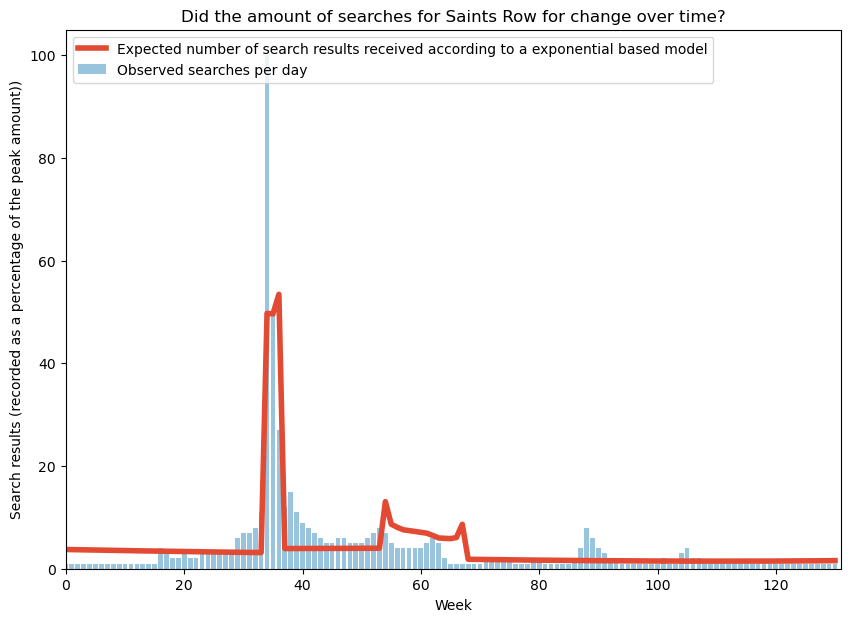

In [30]:
table2Prediction = np.array(toptensecond["Prediction"])
table2ActualData = np.array(toptensecond["Actual Data"])
table2Game = np.array(toptensecond["Game"])
i=0
plt.rcParams['figure.figsize'] = [10, 7]
plt.bar(range(len(table2ActualData[i])), table2ActualData[i], color="#348ABD", alpha=0.5,
    label="Observed searches per day")
plt.xlabel("Week")
plt.ylabel("Search results (recorded as a percentage of the peak amount))")
plt.title(f"Did the amount of searches for {table2Game[i]} for change over time?")
plt.plot(range(len(table2Prediction[i])), table2Prediction[i], color="#E24A33", lw=4,
         label = f"Expected number of search results received according to a exponential based model")
plt.legend(loc="upper left")
plt.xlim(0, len(table2ActualData[i]))
plt.show()

### Worst run

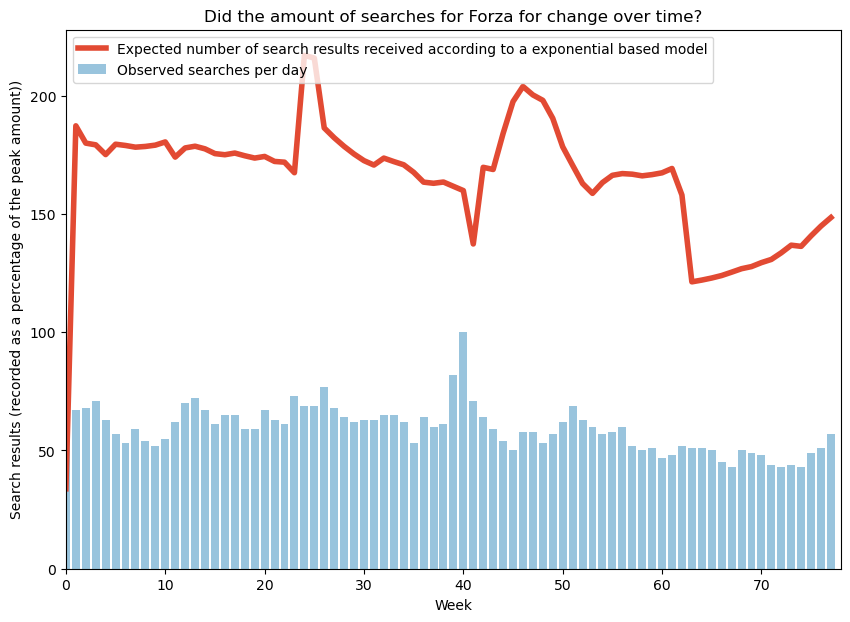

11782.66301662657


In [31]:
ascendingsecond = second_results_database.sort_values("MSE of prediction", ascending=True)
ascendingsecond
table3Prediction = np.array(ascendingsecond["Prediction"])
table3ActualData = np.array(ascendingsecond["Actual Data"])
table3Game = np.array(ascendingsecond["Game"])
MSEtable = np.array(ascendingsecond["MSE of prediction"])
i=-1
plt.rcParams['figure.figsize'] = [10, 7]
plt.bar(range(len(table3ActualData[i])), table3ActualData[i], color="#348ABD", alpha=0.5,
    label="Observed searches per day")
plt.xlabel("Week")
plt.ylabel("Search results (recorded as a percentage of the peak amount))")
plt.title(f"Did the amount of searches for {table3Game[i]} for change over time?")
plt.plot(range(len(table3Prediction[i])), table3Prediction[i], color="#E24A33", lw=4,
         label = f"Expected number of search results received according to a exponential based model")
plt.legend(loc="upper left")
plt.xlim(0, len(table3ActualData[i]))
plt.show()
print(MSEtable[i])

## How each type of search reult data compares to eachother

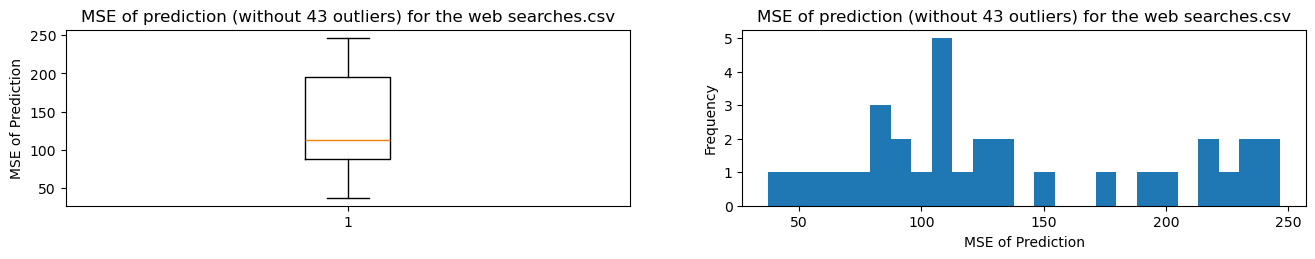

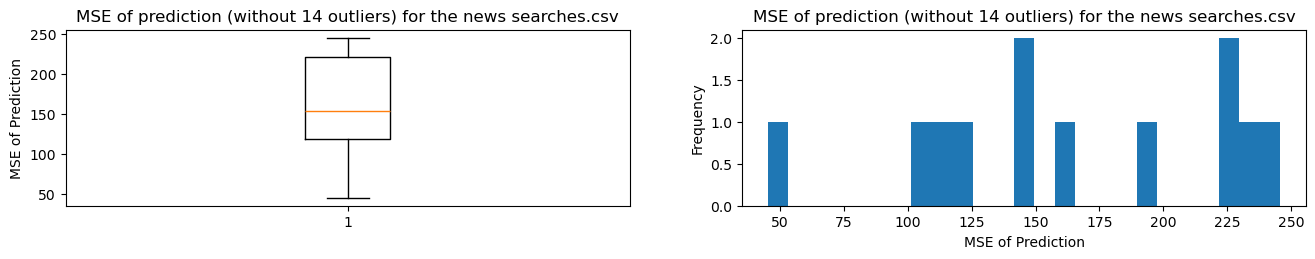

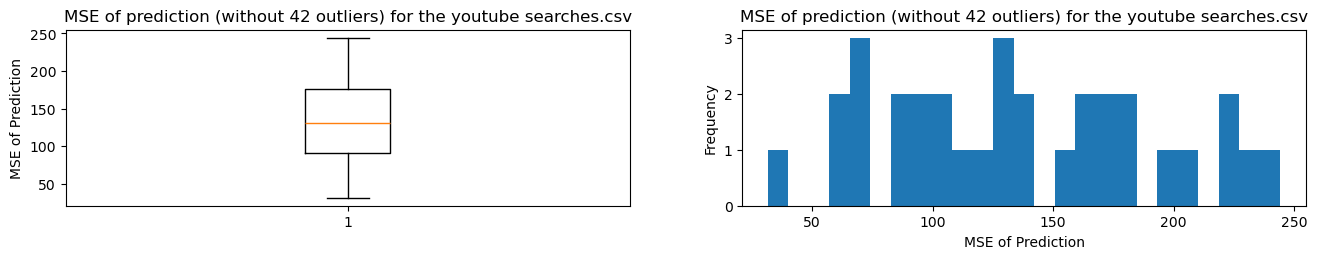

In [32]:
annomali2 = []
average_mse2 = []
min_for_type2 = []
searchlist = ['web searches.csv', 'news searches.csv', 'youtube searches.csv']
for searchtype in searchlist:
    if searchtype == searchlist[1]:
        i = 1
        j = 10
    if searchtype == searchlist[2]:
        i = 2
        j = 20
    else:
        i = 0
        j = 0
        
    data = second_results_database.loc[ (second_results_database['Type of search results file'] == searchtype) ] 
    data2 = second_results_database.loc[ (second_results_database['Type of search results file'] == searchtype) & (second_results_database['MSE of prediction']<=250) ]
    data_filtered = data2.loc[ data2['MSE of prediction']>5 ]
    place1 = 621+i
    place2 = 622+i
    plt.figure(figsize = [16,16])
    plt.subplot(place1)
    plt.boxplot(data_filtered['MSE of prediction'])
    plt.ylabel('MSE of Prediction')
    plt.title(f"MSE of prediction (without {len(data)- len(data_filtered)} outliers) for the {searchtype}")

    plt.subplot(place2)
    plt.hist(data_filtered['MSE of prediction'], bins=25)
    plt.xlabel('MSE of Prediction')
    plt.ylabel('Frequency')
    plt.title(f"MSE of prediction (without {len(data)- len(data_filtered)} outliers) for the {searchtype}")
    
    plt.show()
    annomali2.append([f"The {searchtype} had", {len(data)- len(data_filtered)}, 'potential errors occur'])
    average_mse2.append([f"The {searchtype} had and average MSE of", {np.mean(data_filtered['MSE of prediction'])}])
    min_for_type2.append([f"The {searchtype} had and minimum MSE of", {np.min(data_filtered['MSE of prediction'])}])
    print()
    print()
    print()

In [33]:
annomali2

[['The web searches.csv had', {43}, 'potential errors occur'],
 ['The news searches.csv had', {14}, 'potential errors occur'],
 ['The youtube searches.csv had', {42}, 'potential errors occur']]

In [34]:
average_mse2

[['The web searches.csv had and average MSE of', {135.740231916935}],
 ['The news searches.csv had and average MSE of', {163.04983119434664}],
 ['The youtube searches.csv had and average MSE of', {135.88141589529016}]]

In [35]:
min_for_type2

[['The web searches.csv had and minimum MSE of', {37.234775577479674}],
 ['The news searches.csv had and minimum MSE of', {45.31673787233383}],
 ['The youtube searches.csv had and minimum MSE of', {31.576063324359225}]]